In [616]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import networkx as nx
import plotly.io as pio
import plotly.express as px
import warnings
import re
import kaleido 

from datetime import datetime, timezone
from ipywidgets import interact, DatePicker
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [617]:
df_issues = pd.read_excel('datasets/issues.xlsx')
df_issues_comments = pd.read_excel('datasets/issues_comments.xlsx')
df_pull_requests = pd.read_excel('datasets/pull_requests.xlsx')
df_pull_requests_comments = pd.read_excel('datasets/pull_request_comments.xlsx')

## Issues Age (Difference in Days) by Date of Oppening (Month)

In [618]:
warnings.filterwarnings("ignore") ## Warning generated on timezone.utc library

average_age = df_issues[['id', 'created_at', 'closed_at']]
average_age = average_age[average_age['created_at'].str.startswith('202')]
average_age['created_at'] = pd.to_datetime(average_age['created_at'])
average_age['closed_at'] = pd.to_datetime(average_age['closed_at'])
average_age['closed_at'].fillna(pd.Timestamp.now(timezone.utc), inplace=True)
average_age['average_age'] = (average_age['closed_at'] - average_age['created_at']).dt.days
average_age['created_at_mm_yyyy'] = average_age['created_at'].dt.strftime('%Y-%m')
average_age['closed_at_mm_yyyy'] = average_age['closed_at'].dt.strftime('%Y-%m')
average_age['created_at_mm_yyyy'] = average_age['created_at_mm_yyyy'].astype('category')
average_age = average_age.sort_values(['created_at'], ascending=True)
data_to_plot = [average_age[average_age['created_at_mm_yyyy'] == mm]['average_age'] for mm in average_age['created_at_mm_yyyy'].unique()]

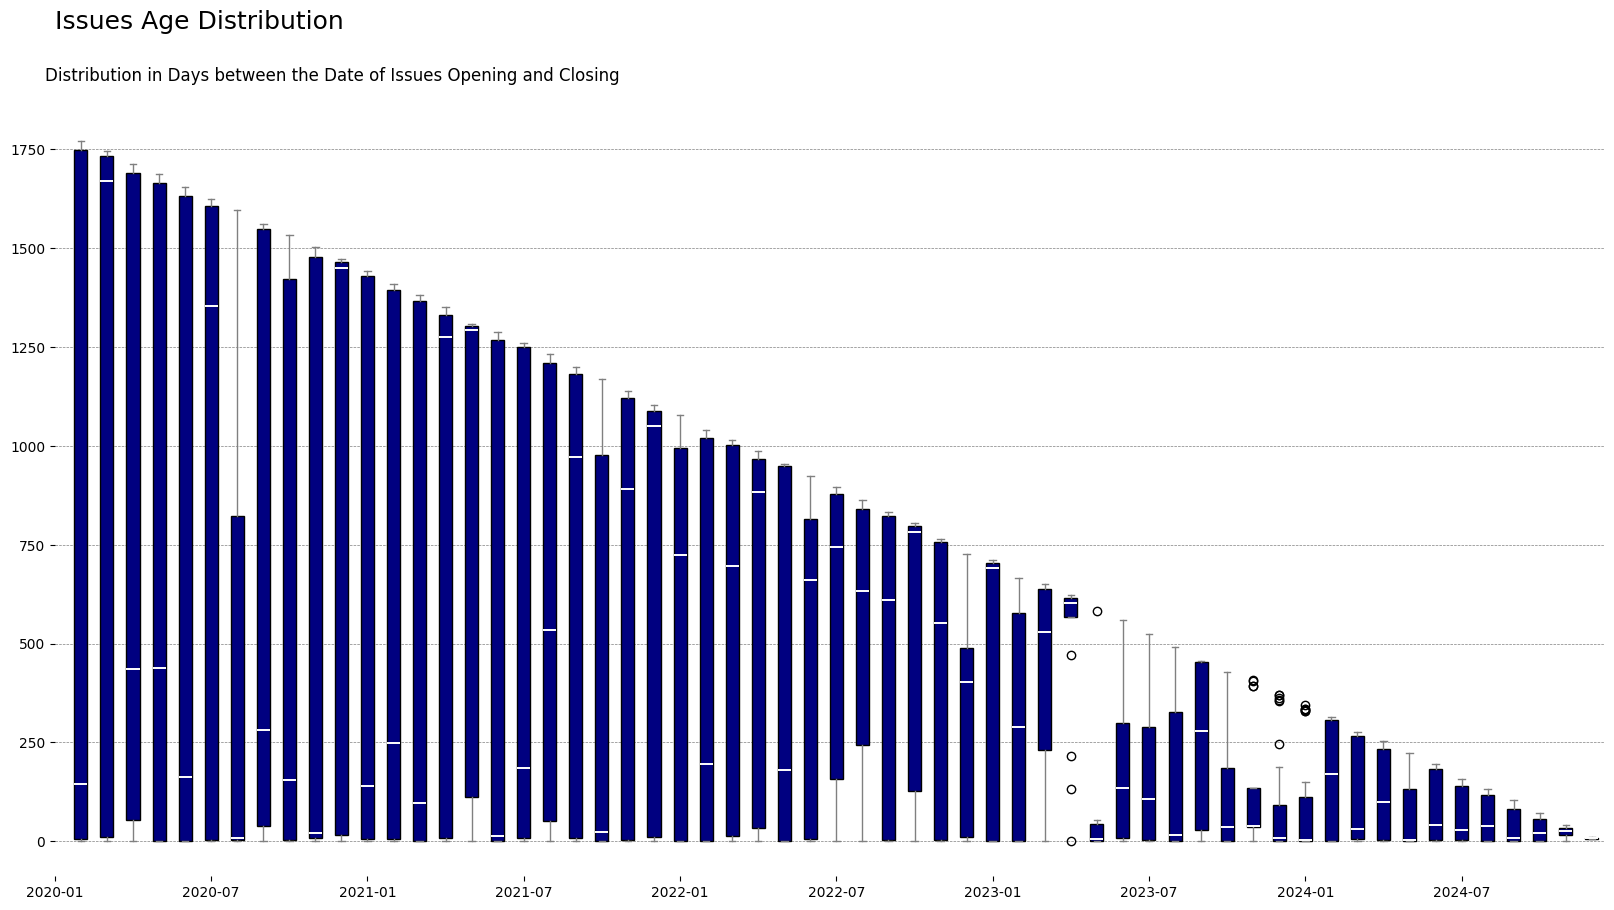

In [619]:
plt.figure(figsize=(20, 10))
box = plt.boxplot(data_to_plot, labels=average_age['created_at_mm_yyyy'].unique(), patch_artist=True)

tick_labels = average_age['created_at_mm_yyyy'].unique()
plt.xticks(ticks=range(0, len(tick_labels)), labels=tick_labels, rotation=0)
num_ticks = len(tick_labels)
plt.xticks(ticks=range(0, num_ticks, 6), labels=tick_labels[::6], rotation=0)

for patch in box['boxes']: patch.set_facecolor('navy') 
for whisker in box['whiskers']: whisker.set_color('gray')
for cap in box['caps']: cap.set_color('gray') 
for median in box['medians']: median.set_color('white'); median.set_linewidth(1.4)
for flier in box['fliers']: flier.set(marker='o', color='gray', alpha=1)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Issues Age Distribution', loc='left', fontsize=18, x=0.0, y=1.09)
plt.suptitle('Distribution in Days between the Date of Issues Opening and Closing', fontsize=12, x=0.12, ha='left', y=0.92)
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)
plt.savefig('images/issue_age_distribution.png')
plt.show()

In [620]:
warnings.filterwarnings("ignore") ## Warning generated on timezone.utc library
full_data = df_issues[['id', 'created_at', 'closed_at']]

full_data['created_at'] = pd.to_datetime(full_data['created_at'])
full_data['closed_at'] = pd.to_datetime(full_data['closed_at'])
full_data['closed_at'].fillna(pd.Timestamp.now(timezone.utc), inplace=True)
full_data['age'] = (full_data['closed_at'] - full_data['created_at']).dt.days
full_data['created_at'] = full_data['created_at'].dt.strftime('%Y-%m')
full_data['closed_at'] = full_data['closed_at'].dt.strftime('%Y-%m')
full_data = full_data.groupby('created_at')['age'].median().reset_index()

In [621]:
min_month = full_data['created_at'].min()
max_month = full_data['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})
full_data['created_at'] = pd.to_datetime(full_data['created_at']).dt.to_period('M')

In [622]:
full_data = pd.merge(all_months, full_data, on='created_at', how='left')
full_data['age'] = full_data['age'].fillna(0)
full_data['created_at'] = full_data['created_at'].dt.strftime('%Y-%m')

In [623]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['age'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['age'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [624]:
months = full_data['created_at']
mean_values = full_data['age']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Issue Mean Age (Days)',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Issues Mean Age by Month',
    xaxis_title='Months',
    yaxis_title='Issues Mean Age (Days)',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-1, max(mean_values) * 1.1], dtick=50),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.095,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/issues_mean_age.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

## Pull Requests Age (Difference in Days) by Date of Openning (Month)

In [625]:
warnings.filterwarnings("ignore") ## Warning generated on timezone.utc library

average_age = df_pull_requests[['id', 'created_at', 'closed_at']]
average_age = average_age[average_age['created_at'].str.startswith('202')]

average_age['created_at'] = pd.to_datetime(average_age['created_at'])
average_age['closed_at'] = pd.to_datetime(average_age['closed_at'])
average_age['closed_at'].fillna(pd.Timestamp.now(timezone.utc), inplace=True)
average_age['average_age'] = (average_age['closed_at'] - average_age['created_at']).dt.days
average_age['created_at_mm_yyyy'] = average_age['created_at'].dt.strftime('%Y-%m')
average_age['closed_at_mm_yyyy'] = average_age['closed_at'].dt.strftime('%Y-%m')
average_age['created_at_mm_yyyy'] = average_age['created_at_mm_yyyy'].astype('category')
average_age = average_age.sort_values(['created_at'], ascending=True)

data_to_plot = [average_age[average_age['created_at_mm_yyyy'] == mm]['average_age'] for mm in average_age['created_at_mm_yyyy'].unique()]

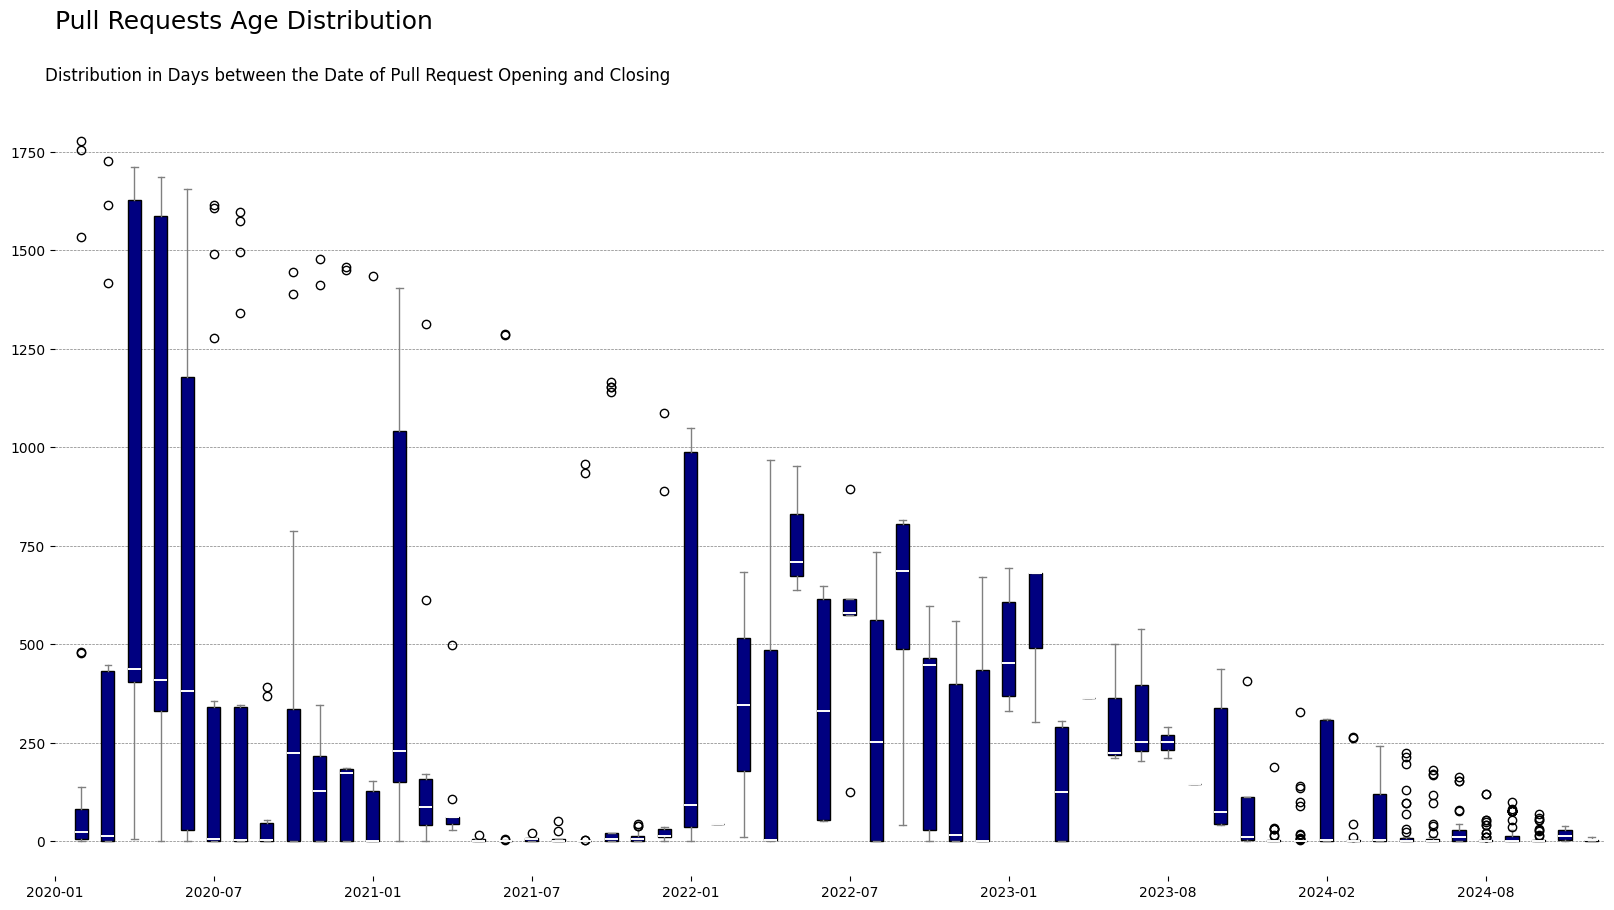

In [626]:
plt.figure(figsize=(20, 10))
box = plt.boxplot(data_to_plot, labels=average_age['created_at_mm_yyyy'].unique(), patch_artist=True)

tick_labels = average_age['created_at_mm_yyyy'].unique()
plt.xticks(ticks=range(0, len(tick_labels)), labels=tick_labels, rotation=0)
num_ticks = len(tick_labels)
plt.xticks(ticks=range(0, num_ticks, 6), labels=tick_labels[::6], rotation=0)

for patch in box['boxes']: patch.set_facecolor('navy') 
for whisker in box['whiskers']: whisker.set_color('gray')
for cap in box['caps']: cap.set_color('gray') 
for median in box['medians']: median.set_color('white'); median.set_linewidth(1.4)
for flier in box['fliers']: flier.set(marker='o', color='gray', alpha=1)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Pull Requests Age Distribution', loc='left', fontsize=18, x=0.0, y=1.09)
plt.suptitle('Distribution in Days between the Date of Pull Request Opening and Closing', fontsize=12, x=0.12, ha='left', y=0.92)
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.savefig('images/pull_request_age_distribution.png')
plt.show()

In [627]:
warnings.filterwarnings("ignore") ## Warning generated on timezone.utc library
full_data = df_pull_requests[['id', 'created_at', 'closed_at']]

full_data['created_at'] = pd.to_datetime(full_data['created_at'])
full_data['closed_at'] = pd.to_datetime(full_data['closed_at'])
full_data['closed_at'].fillna(pd.Timestamp.now(timezone.utc), inplace=True)
full_data['age'] = (full_data['closed_at'] - full_data['created_at']).dt.days
full_data['created_at'] = full_data['created_at'].dt.strftime('%Y-%m')
full_data['closed_at'] = full_data['closed_at'].dt.strftime('%Y-%m')
full_data = full_data.groupby('created_at')['age'].median().reset_index()

In [628]:
min_month = full_data['created_at'].min()
max_month = full_data['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})
full_data['created_at'] = pd.to_datetime(full_data['created_at']).dt.to_period('M')
full_data = pd.merge(all_months, full_data, on='created_at', how='left')
full_data['age'] = full_data['age'].fillna(0)
full_data['created_at'] = full_data['created_at'].dt.strftime('%Y-%m')

In [629]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['age'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['age'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [630]:
months = full_data['created_at']
mean_values = full_data['age']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Pull Request Mean Age',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Pull Requests Mean Age by Month',
    xaxis_title='Months',
    yaxis_title='Pull Requests Mean Age',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-1, max(mean_values) * 1.1], dtick=50),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.095,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/pull_request_mean_age.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

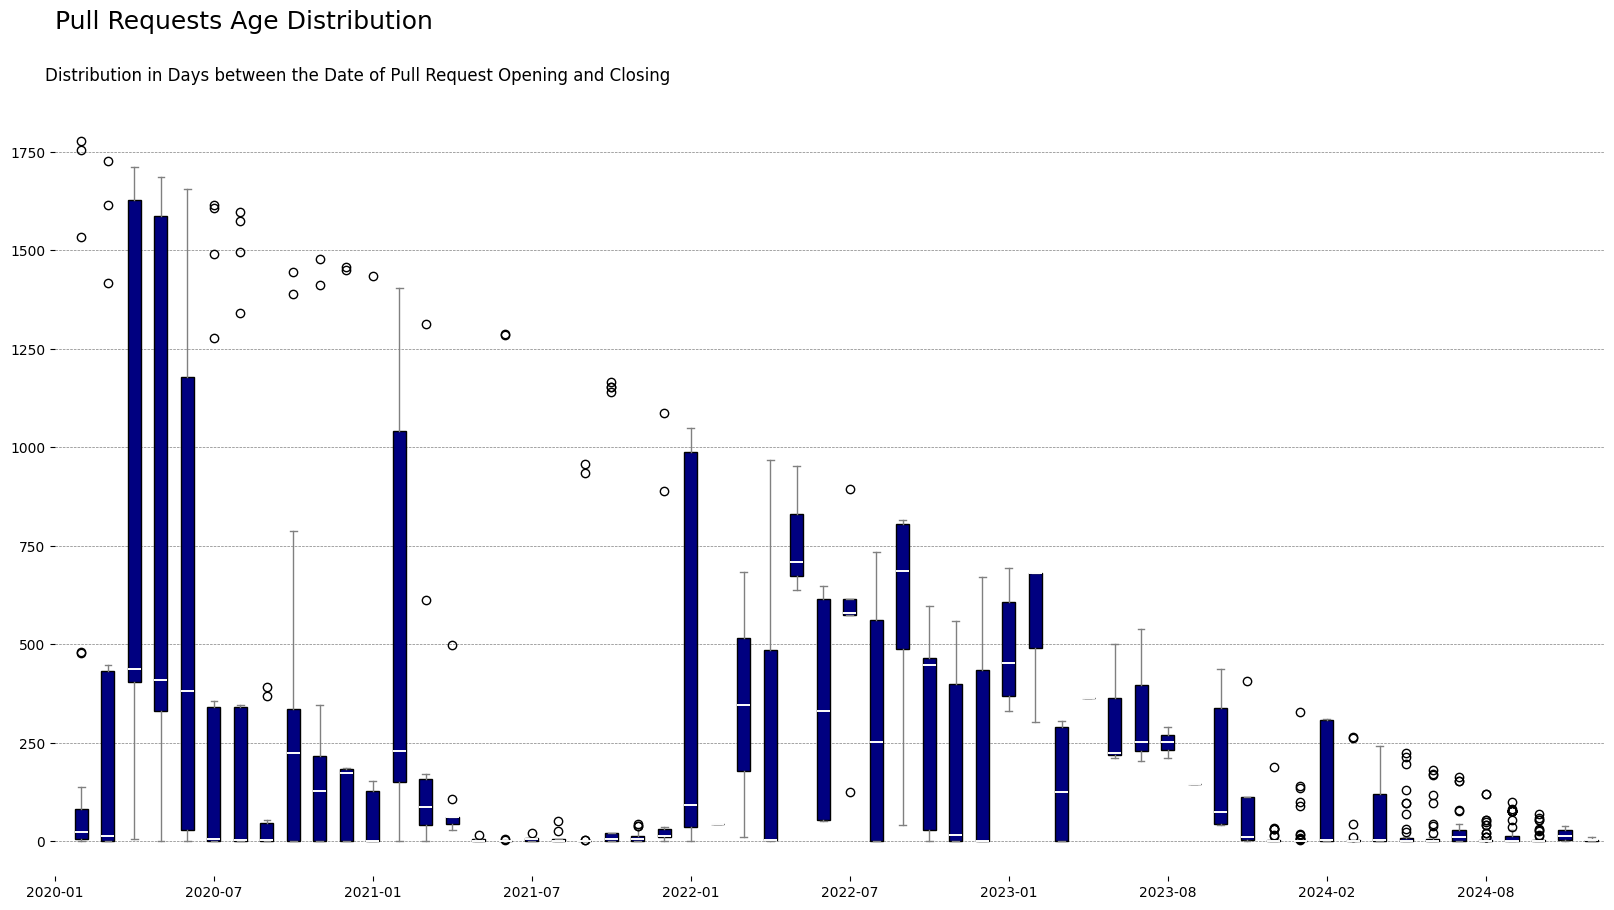

In [631]:
plt.figure(figsize=(20, 10))
box = plt.boxplot(data_to_plot, labels=average_age['created_at_mm_yyyy'].unique(), patch_artist=True)

tick_labels = average_age['created_at_mm_yyyy'].unique()
plt.xticks(ticks=range(0, len(tick_labels)), labels=tick_labels, rotation=0)
num_ticks = len(tick_labels)
plt.xticks(ticks=range(0, num_ticks, 6), labels=tick_labels[::6], rotation=0)

for patch in box['boxes']: patch.set_facecolor('navy') 
for whisker in box['whiskers']: whisker.set_color('gray')
for cap in box['caps']: cap.set_color('gray') 
for median in box['medians']: median.set_color('white'); median.set_linewidth(1.4)
for flier in box['fliers']: flier.set(marker='o', color='gray', alpha=1)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Pull Requests Age Distribution', loc='left', fontsize=18, x=0.0, y=1.09)
plt.suptitle('Distribution in Days between the Date of Pull Request Opening and Closing', fontsize=12, x=0.12, ha='left', y=0.92)
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.savefig('images/pull_request_age_distribution.png')
plt.show()

## Pull Requests Opened and Closed by Month

In [632]:
warnings.filterwarnings("ignore") ## Warning generated on timezone.utc library

average_age = df_pull_requests[['id', 'created_at', 'closed_at']]
average_age['created_at'] = pd.to_datetime(average_age['created_at'])
average_age['closed_at'] = pd.to_datetime(average_age['closed_at'])
average_age = average_age[average_age['closed_at'].notna()]
average_age['average_age'] = (average_age['closed_at'] - average_age['created_at']).dt.days
average_age['created_at_mm_yyyy'] = average_age['created_at'].dt.strftime('%Y-%m')
average_age['closed_at_mm_yyyy'] = average_age['closed_at'].dt.strftime('%Y-%m')

In [633]:
average_age_closed = average_age\
    .groupby('closed_at_mm_yyyy')['average_age']\
    .agg(['mean', 'max', 'min', 'count'])

average_age_closed['mean'] = average_age_closed['mean'].round(1)
average_age_closed = average_age_closed.reset_index()

In [634]:
average_age = average_age\
    .groupby('created_at_mm_yyyy')['average_age']\
    .agg(['mean', 'max', 'min', 'count'])

average_age['mean'] = average_age['mean'].round(1)
average_age = average_age.reset_index()

In [635]:
opened_df = average_age.rename(
        columns = {
            'created_at_mm_yyyy': 'month', 
            'count': 'count_opened'
        }
    )[['month', 'count_opened']]

closed_df = average_age_closed.rename(
        columns = {
            'closed_at_mm_yyyy': 'month', 
            'count': 'count_closed'
        }
    )[['month', 'count_closed']]

merged_df = pd.merge(
        opened_df,
        closed_df,
        on = 'month',
        how = 'outer'
    ).fillna(0) 

In [636]:
months = merged_df['month']
opened_counts = merged_df['count_opened']
closed_counts = merged_df['count_closed']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=opened_counts,
    name='Pull Requests Opened',
    marker=dict(color='orangered')
))

fig.add_trace(go.Bar(
    x=months,
    y=closed_counts,
    name='Pull Requests Closed',
    marker=dict(color='navy')
))

fig.update_layout(
    title='Opened and Closed Pull Requests Rate',
    xaxis_title='Months',
    yaxis_title='Number of Pull Requests',
    yaxis=dict(range=[0, max(max(opened_counts), max(closed_counts)) * 1.1]),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='center', x=0.5),
    annotations=[
        dict(
            text='Number of Pull Requests Opened and Closed by Month',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(max(opened_counts), max(closed_counts)) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/opened_closed_pull_requests_age.png')

fig.update_layout(
    annotations=[
        dict(
            text='Number of Pull Requests Opened and Closed by Month',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.125,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)
fig.update_xaxes(
    rangeslider_visible=True,
    range=[months.min(), months.max()]
)

fig.show()

In [637]:
merged_df['activity'] = merged_df['count_closed'] - merged_df['count_opened']

In [638]:
months = merged_df['month']
activity = merged_df['activity']
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=months,
    y=activity.where(activity >= 0, 0), 
    mode='lines',
    line=dict(color='rgba(0, 0, 0, 0)', width=2),  
    fill='tozeroy',
    fillcolor='rgba(0, 0, 128, 0.8)', 
    name='Predominant Activity: Closing Pull Requests'
))

fig.add_trace(go.Scatter(
    x=months,
    y=activity.where(activity <= 0, 0), 
    mode='lines',
    line=dict(color='rgba(0, 0, 0, 0)', width=2),  
    fill='tozeroy',
    fillcolor='rgba(255, 69, 0, 0.8)',
    name='Predominant Activity: Opening Pull Requests'
))

fig.add_trace(go.Scatter(
    x=months,
    y=activity,
    mode='lines+markers',
    name='Sample Data',
    line=dict(color='black'),  
    marker=dict(color='black')
))

fig.update_layout(
    title='Predominant Community Activity',
    xaxis_title='Months',
    yaxis_title='Activity',
    xaxis=dict(tickmode='array', tickvals=months[::8], ticktext=months[::8]),
    yaxis=dict(range=[min(activity) * 1.1, max(activity) * 1.1]),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.0,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Predominant Activity: Opening Pull Requests',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[min(activity) * 1.1, max(activity) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/predominant_community_pr_activity.png')

fig.update_xaxes(
    rangeslider_visible=True,
    range=[months.min(), months.max()]
)

fig.show()

## Number of Contributors in the Community [Opening Pull Requesting]

In [639]:
pull_request_contributors = df_pull_requests[['id', 'created_by', 'created_at']]

In [640]:
pull_request_contributors['created_by'] = pull_request_contributors['created_by']\
    .str\
    .replace(
        'https://api.github.com/users/', 
        '', 
        regex = False
    )

pull_request_contributors['created_at'] = pd.to_datetime(pull_request_contributors['created_at'], errors='coerce').dt.strftime('%Y-%m')

pull_request_contributors = pull_request_contributors\
    .groupby(['created_by', 'created_at'])\
    .count()\
    .reset_index()

In [641]:
pull_request_contributors = pull_request_contributors\
    .groupby('created_at')\
    .count()\
    .reset_index()\
    [['created_at', 'created_by']]\
    .rename(
        columns = {'created_by': 'number_of_users'}
    )

In [642]:
min_month = pull_request_contributors['created_at'].min()
max_month = pull_request_contributors['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})
pull_request_contributors['created_at'] = pd.to_datetime(pull_request_contributors['created_at']).dt.to_period('M')
pull_request_contributors = pd.merge(all_months, pull_request_contributors, on='created_at', how='left')
pull_request_contributors['number_of_users'] = pull_request_contributors['number_of_users'].fillna(0)
pull_request_contributors['created_at'] = pull_request_contributors['created_at'].dt.strftime('%Y-%m')

In [643]:
mask_1 = (pull_request_contributors['created_at'] >= '2023-02') & (pull_request_contributors['created_at'] <= '2023-11')
mask_2 = (pull_request_contributors['created_at'] >= '2024-01') & (pull_request_contributors['created_at'] <= '2024-10')

data_1 = pull_request_contributors[mask_1]
data_2 = pull_request_contributors[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [644]:
months = pull_request_contributors['created_at']
mean_values = pull_request_contributors['number_of_users']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Active Pull Request Openers',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=7),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=7),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Community Active Members',
    xaxis_title='Months',
    yaxis_title='Number of Active Users',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-1, max(mean_values) * 1.1], dtick=3),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Number of active users (pull request openers) inside the community per month',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.095,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_pr_active_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

## Number of Contributors in the Community [All Activities]

In [645]:
pull_request_contributors_v2 = df_pull_requests[['id', 'created_by', 'created_at']]
pull_requests_comments_contributors = df_pull_requests_comments[['id', 'created_by', 'created_at']]
issues_contributors = df_issues[['id', 'created_by', 'created_at']]
issues_comments_contributors = df_issues_comments[['id', 'created_by', 'created_at']]

In [646]:
pull_request_contributors_v2['created_by'] = pull_request_contributors_v2['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
issues_contributors['created_by'] = issues_contributors['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
pull_requests_comments_contributors['created_by'] = pull_requests_comments_contributors['created_by'].str.extract(r'login="([^"]+)"')

In [647]:
community_activity = result = pd.concat(
    [pull_request_contributors_v2, pull_requests_comments_contributors, issues_contributors, issues_comments_contributors], 
    ignore_index=True
)

community_activity['created_by'] = community_activity['created_by']\
    .str\
    .replace(
        'https://api.github.com/users/', 
        '', 
        regex = False
    )

community_activity['created_at'] = pd.to_datetime(community_activity['created_at'], errors='coerce').dt.strftime('%Y-%m')
community_activity = community_activity.groupby(['created_by', 'created_at']).count().reset_index()

In [648]:
community_activity = community_activity\
    .groupby('created_at')\
    .count()\
    .reset_index()\
    [['created_at', 'created_by']]\
    .rename(
        columns = {'created_by': 'number_of_users'}
    )

In [649]:
mask_1 = (community_activity['created_at'] >= '2023-02') & (community_activity['created_at'] <= '2023-11')
mask_2 = (community_activity['created_at'] >= '2024-01') & (community_activity['created_at'] <= '2024-10')

data_1 = community_activity[mask_1]
data_2 = community_activity[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [650]:
months = community_activity['created_at']
mean_values = community_activity['number_of_users']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Active Members',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=7),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=7),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Community Active Members',
    xaxis_title='Months',
    yaxis_title='Number of Active Users',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-2, max(mean_values) * 1.1], dtick=10),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Number of active users (all types of contributions) inside the community per month',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_active_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()


In [651]:
comparison_community_activity_pr_not_pr = pd.merge(
    community_activity, 
    pull_request_contributors, 
    on = ['created_at'], 
    how = "outer"
)

comparison_community_activity_pr_not_pr['number_of_users_yx'] = comparison_community_activity_pr_not_pr['number_of_users_y'] / comparison_community_activity_pr_not_pr['number_of_users_x']
comparison_community_activity_pr_not_pr['number_of_users_yx'] = comparison_community_activity_pr_not_pr['number_of_users_yx'].fillna(0)

In [652]:
mask_1 = (comparison_community_activity_pr_not_pr['created_at'] >= '2023-02') & (comparison_community_activity_pr_not_pr['created_at'] <= '2023-11')
mask_2 = (comparison_community_activity_pr_not_pr['created_at'] >= '2024-01') & (comparison_community_activity_pr_not_pr['created_at'] <= '2024-10')

data_1 = comparison_community_activity_pr_not_pr[mask_1]
data_2 = comparison_community_activity_pr_not_pr[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users_yx'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users_yx'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [653]:
months = comparison_community_activity_pr_not_pr['created_at']
mean_values = comparison_community_activity_pr_not_pr['number_of_users_y'] / comparison_community_activity_pr_not_pr['number_of_users_x']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Proportion Active PR Focused Members',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Community Active Proportion PR Focused Members',
    xaxis_title='Months',
    yaxis_title='Active Members Ratio',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-0.01, max(mean_values) * 1.1], dtick=0.05),
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Proportion of Active Members Focused on Opening Pull Requests inside the Community',
            xref='paper',
            yref='paper',
            x=-0.009,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_proportion_pr_active_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()


## Number of New Contributors Month by Month in the Community [Opening Pull Requesting]

In [654]:
pull_request_contributors = df_pull_requests[['id', 'created_by', 'created_at']]

In [655]:
pull_request_contributors['created_by'] = pull_request_contributors['created_by']\
    .str\
    .replace(
        'https://api.github.com/users/', 
        '', 
        regex = False
    )

pull_request_contributors['created_at'] = pd.to_datetime(pull_request_contributors['created_at'], errors='coerce').dt.strftime('%Y-%m')
pull_request_contributors = pull_request_contributors.sort_values(['created_at'], ascending=True)

In [656]:
grouped_data = pull_request_contributors\
    .groupby('created_by')\
    .agg(all_values = ('created_at', list))\
    .reset_index()

In [657]:
pull_request_contributors = pull_request_contributors\
    .groupby(['created_by'])\
    .first()\
    .reset_index()

In [658]:
pull_request_contributors = pull_request_contributors\
    .groupby('created_at')\
    .count()\
    .reset_index()\
    [['created_at', 'created_by']]\
    .rename(
        columns = {'created_by': 'number_of_users'}
    )

In [659]:
pull_request_contributors['created_at'] = pd.to_datetime(pull_request_contributors['created_at'])
pull_request_contributors['created_at'] = pull_request_contributors['created_at'].dt.to_period('M')

In [660]:
min_month = pull_request_contributors['created_at'].min()
max_month = pull_request_contributors['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})

In [661]:
full_data = pd.merge(all_months, pull_request_contributors, on='created_at', how='left')
full_data['number_of_users'] = full_data['number_of_users'].fillna(0)

In [662]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [663]:
months = full_data['created_at'].astype(str)
mean_values = full_data['number_of_users']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Number of New Users',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))


fig.update_layout(
    title='Community New Members (Pull Request Openers)',
    xaxis_title='Months',
    yaxis_title='Number of New Users',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-1, max(mean_values) * 1.1], dtick=3), 
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Number of new users (pull request openers) inside the community per month',
            xref='paper',
            yref='paper',
            x=-0.01,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_pr_new_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

## Number of New Contributors Month by Month in the Community [All Activities]

In [664]:
pull_request_contributors_v2 = df_pull_requests[['created_by', 'created_at']]
pull_requests_comments_contributors = df_pull_requests_comments[['created_by', 'created_at']]
issues_contributors = df_issues[['created_by', 'created_at']]
issues_comments_contributors = df_issues_comments[['created_by', 'created_at']]

In [665]:
pull_request_contributors_v2['created_by'] = pull_request_contributors_v2['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
issues_contributors['created_by'] = issues_contributors['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
pull_requests_comments_contributors['created_by'] = pull_requests_comments_contributors['created_by'].str.extract(r'login="([^"]+)"')

In [666]:
community_activity = result = pd.concat(
    [pull_request_contributors_v2, pull_requests_comments_contributors, issues_contributors, issues_comments_contributors], 
    ignore_index=True
)

In [667]:
community_activity = community_activity.sort_values(['created_at'], ascending=True)
community_activity['created_at'] = pd.to_datetime(community_activity['created_at'], errors='coerce').dt.strftime('%Y-%m')

In [668]:
community_activity = community_activity.drop_duplicates()

In [669]:
grouped_data = community_activity\
    .groupby('created_by')\
    .agg(all_values = ('created_at', list))\
    .reset_index()

In [670]:
community_activity = community_activity\
    .groupby(['created_by'])\
    .first()\
    .reset_index()

In [671]:
community_activity = community_activity\
    .groupby('created_at')\
    .count()\
    .reset_index()\
    [['created_at', 'created_by']]\
    .rename(
        columns = {'created_by': 'number_of_users'}
    )

In [672]:
min_month = community_activity['created_at'].min()
max_month = community_activity['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})

In [673]:
community_activity['created_at'] = pd.to_datetime(community_activity['created_at']).dt.to_period('M')

In [674]:
full_data = pd.merge(all_months, community_activity, on='created_at', how='left')
full_data['number_of_users'] = full_data['number_of_users'].fillna(0)

In [675]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [676]:
months = full_data['created_at'].astype(str)
mean_values = full_data['number_of_users']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Number of New Users',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=7),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=7),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Community New Members',
    xaxis_title='Months',
    yaxis_title='Number of New Users',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[0, 55], dtick=5), 
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Number of new users (all activities) inside the community per month',
            xref='paper',
            yref='paper',
            x=-0.01,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_new_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()


## Number of Reviewers in Pull Requests By Month

In [677]:
pr_reviewers_by_month = df_pull_requests_comments[['created_by', 'created_at']]

In [678]:
pr_reviewers_by_month['created_by'] = pr_reviewers_by_month['created_by'].str.extract(r'login="([^"]+)"')
pr_reviewers_by_month['created_at'] = pd.to_datetime(pr_reviewers_by_month['created_at'], errors='coerce').dt.strftime('%Y-%m')
pr_reviewers_by_month = pr_reviewers_by_month.drop_duplicates()
pr_reviewers_by_month = pr_reviewers_by_month.groupby(['created_at']).count().reset_index()
pr_reviewers_by_month = pr_reviewers_by_month.rename(columns={'created_by': 'number_of_reviewers'})

In [679]:
min_month = community_activity['created_at'].min()
max_month = community_activity['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})

In [680]:
pr_reviewers_by_month['created_at'] = pd.to_datetime(pr_reviewers_by_month['created_at']).dt.to_period('M')

In [681]:
full_data = pd.merge(all_months, pr_reviewers_by_month, on='created_at', how='left')
full_data['number_of_reviewers'] = full_data['number_of_reviewers'].fillna(0)

In [682]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_reviewers'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_reviewers'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [683]:
months = full_data['created_at'].astype(str)
mean_values = full_data['number_of_reviewers']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Number of Reviewers',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Number of reviewers (Pull Requests) inside the community per month',
    xaxis_title='Months',
    yaxis_title='Number of Reviewers',
    xaxis=dict(
        tickmode='array',
        rangeslider=dict(visible=False),
        tickformat='%Y-%m', 
    ),
    yaxis=dict(range=[-2, max(mean_values) * 1.1]),
    hovermode='x unified',
    width=1400, 
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    )
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_pr_reviewers.png')

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

## Backlog Analysis

In [684]:
df_issues_backlog = df_issues[['id', 'created_at', 'closed_at']].replace('NaT', None)
df_issues_backlog['created_at'] = pd.to_datetime(df_issues_backlog['created_at'], errors='coerce').dt.strftime('%Y-%m')
df_issues_backlog['closed_at'] = pd.to_datetime(df_issues_backlog['closed_at'], errors='coerce').dt.strftime('%Y-%m')

min_month = df_issues_backlog['created_at'].min()
max_month = df_issues_backlog['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M').astype(str)})

In [685]:
list_size_backlog = list()

for _, row in all_months.iterrows():
    current_month = row['created_at']
    backlog_count = df_issues_backlog[
        (df_issues_backlog['created_at'] <= current_month) & 
        ((df_issues_backlog['closed_at'].isna()) | (df_issues_backlog['closed_at'] > current_month))
    ].shape[0]
    
    list_size_backlog.append({'month': current_month, 'backlog_count': backlog_count})

backsize_log_issue_df = pd.DataFrame(list_size_backlog)

In [686]:
mask_1 = (backsize_log_issue_df['month'] >= '2023-02') & (backsize_log_issue_df['month'] <= '2023-11')
mask_2 = (backsize_log_issue_df['month'] >= '2024-01') & (backsize_log_issue_df['month'] <= '2024-10')

data_1 = backsize_log_issue_df[mask_1]
data_2 = backsize_log_issue_df[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['backlog_count'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['backlog_count'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [687]:
months = backsize_log_issue_df['month'].astype(str)
mean_values = backsize_log_issue_df['backlog_count']
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=months,
    y=mean_values,
    mode='lines+markers',
    name='Backlog Size',
    line=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['month'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['month'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Backlog Count (Issues) per Month',
    xaxis_title='Months',
    yaxis_title='Number of Issues with Open Status',
    xaxis=dict(
        tickmode='array',
        rangeslider=dict(visible=False),
        tickformat='%Y-%m', 
    ),
    yaxis=dict(range=[-2, max(mean_values) * 1.1]),
    hovermode='x unified',
    width=1400, 
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    )
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/issue_backlog_count.png')

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

In [688]:
df_pr_backlog = df_pull_requests[['id', 'created_at', 'closed_at']].replace('NaT', None)
df_pr_backlog['created_at'] = pd.to_datetime(df_pr_backlog['created_at'], errors='coerce').dt.strftime('%Y-%m')
df_pr_backlog['closed_at'] = pd.to_datetime(df_pr_backlog['closed_at'], errors='coerce').dt.strftime('%Y-%m')

min_month = df_pr_backlog['created_at'].min()
max_month = df_pr_backlog['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M').astype(str)})

In [689]:
list_size_backlog = list()

for _, row in all_months.iterrows():
    current_month = row['created_at']
    backlog_count = df_pr_backlog[
        (df_pr_backlog['created_at'] <= current_month) & 
        ((df_pr_backlog['closed_at'].isna()) | (df_pr_backlog['closed_at'] > current_month))
    ].shape[0]
    
    list_size_backlog.append({'month': current_month, 'backlog_count': backlog_count})

backsize_log_pr_df = pd.DataFrame(list_size_backlog)

In [690]:
mask_1 = (backsize_log_pr_df['month'] >= '2023-02') & (backsize_log_pr_df['month'] <= '2023-11')
mask_2 = (backsize_log_pr_df['month'] >= '2024-01') & (backsize_log_pr_df['month'] <= '2024-10')

data_1 = backsize_log_pr_df[mask_1]
data_2 = backsize_log_pr_df[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['backlog_count'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['backlog_count'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [691]:
months = backsize_log_pr_df['month'].astype(str)
mean_values = backsize_log_pr_df['backlog_count']
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=months,
    y=mean_values,
    mode='lines+markers',
    name='Backlog Size',
    line=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['month'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=4),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['month'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=4),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Backlog Count (Pull Requests) per Month',
    xaxis_title='Months',
    yaxis_title='Number of Pull Requests with Open Status',
    xaxis=dict(
        tickmode='array',
        rangeslider=dict(visible=False),
        tickformat='%Y-%m', 
    ),
    yaxis=dict(range=[-2, max(mean_values) * 1.1]),
    hovermode='x unified',
    width=1400, 
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    )
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/pull_request_backlog_count.png')

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()

## PR Activity Revisor Analysis

In [736]:
pr_reviewers_by_month = df_pull_requests_comments[['created_by', 'created_at', 'pull_request_id']]
pr_reviewers_by_month['created_by'] = pr_reviewers_by_month['created_by'].str.extract(r'login="([^"]+)"')
pr_reviewers_by_month['created_at'] = pd.to_datetime(pr_reviewers_by_month['created_at'], errors='coerce').dt.strftime('%Y-%m')
pr_reviewers_by_month = pr_reviewers_by_month.drop_duplicates()
pr_reviewers_by_month = pr_reviewers_by_month.groupby(['created_at', 'created_by']).count().reset_index()
pr_reviewers_by_month = pr_reviewers_by_month.rename(columns={'pull_request_id': 'number_of_revisions'})
pr_reviewers_by_month = pr_reviewers_by_month[pr_reviewers_by_month['created_at'] >= '2022-01']

y_min = pr_reviewers_by_month['created_by'].iloc[:1]
y_max = pr_reviewers_by_month['created_by'].iloc[len(pr_reviewers_by_month) - 1: len(pr_reviewers_by_month)]

In [748]:
fig = px.scatter(
    pr_reviewers_by_month,
    x='created_at',
    y='created_by',
    size='number_of_revisions',
    color='number_of_revisions',
    color_continuous_scale='Agsunset', 
    size_max=20, 
    labels={
        'created_at': 'Month', 
        'created_by': 'User', 
        'number_of_revisions': 'Revisions'
    },
    title='Number of Revisions per User by Month'
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="User",
    legend_title_text='',
    template="plotly_white",
    height=1080,
    width=920
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[y_min.values[0], y_max.values[0]],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.update_layout(
    legend=dict(
        x=0.5,
        y=1,
        xanchor='center',
        yanchor='top', 
        orientation="h"
    )
)

fig.write_image('images/pr_revisions_by_user.png')
fig.show()

In [694]:
pr_reviewers_by_month = df_pull_requests_comments[['created_by', 'created_at', 'pull_request_id']]
pr_reviewers_by_month['created_by'] = pr_reviewers_by_month['created_by'].str.extract(r'login="([^"]+)"')
pr_reviewers_by_month['created_at'] = pd.to_datetime(pr_reviewers_by_month['created_at'], errors='coerce').dt.strftime('%Y-%m')
pr_reviewers_by_month = pr_reviewers_by_month.drop_duplicates()
pr_reviewers_by_month = pr_reviewers_by_month.groupby(['created_at', 'created_by']).count().reset_index()
pr_reviewers_by_month = pr_reviewers_by_month.rename(columns={'pull_request_id': 'number_of_revisions'})
pr_reviewers_by_month = pr_reviewers_by_month[pr_reviewers_by_month['created_at'] >= '2022-01']

In [695]:
fig = px.box(
    pr_reviewers_by_month, 
    x='created_at', 
    y='number_of_revisions', 
    title='Number of Revisions by Month',
)

fig.update_layout(
    height = 800,
    width = 1500
)

fig.update_traces(
    fillcolor='darkGray',
    line=dict(color='black'),
    marker=dict(color='red', size=6)
)

fig.write_image('images/boxplot_pr_revisions_by_user.png')
fig.show()

## PR Distribution per User

In [749]:
pr_creators_by_month = df_pull_requests[['created_by', 'created_at', 'id']]
pr_creators_by_month['created_by'] = pr_creators_by_month['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
pr_creators_by_month['created_at'] = pd.to_datetime(pr_creators_by_month['created_at'], errors='coerce').dt.strftime('%Y-%m')
pr_creators_by_month = pr_creators_by_month.drop_duplicates()
pr_creators_by_month = pr_creators_by_month.groupby(['created_at', 'created_by']).count().reset_index()
pr_creators_by_month = pr_creators_by_month.rename(columns={'id': 'number_of_pr_created'})
pr_creators_by_month = pr_creators_by_month[pr_creators_by_month['created_at'] >= '2022-01']

y_min = pr_creators_by_month['created_by'].iloc[:1]
y_max = pr_creators_by_month['created_by'].iloc[len(pr_creators_by_month) - 1: len(pr_creators_by_month)]

In [750]:
fig = px.scatter(
    pr_creators_by_month,
    x='created_at',
    y='created_by',
    size='number_of_pr_created',
    color='number_of_pr_created',
    color_continuous_scale='Agsunset', 
    size_max=20, 
    labels={'created_at': 'Month', 'created_by': 'User', 'number_of_pr_created': 'PR Created'},
    title='Number of PR Created per User by Month'
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="User",
    legend_title_text='Revisions',
    template="plotly_white",
    height=1080,
    width=920
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[y_min.values[0], y_max.values[0]],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.update_layout(
    legend=dict(
        x=0.5,
        y=1,
        xanchor='center',
        yanchor='top', 
        orientation="h"
    )
)

fig.write_image('images/pr_created_by_user.png')
fig.show()

In [698]:
fig = px.box(
    pr_creators_by_month, 
    x='created_at', 
    y='number_of_pr_created', 
    title='Number of PR by Month',
)

fig.update_layout(
    height = 800,
    width = 1500
)

fig.update_traces(
    fillcolor='darkGray',
    line=dict(color='black'),
    marker=dict(color='red', size=6)
)

fig.write_image('images/boxplot_pr_created_by_user.png')
fig.show()

## Contributors Retention

In [699]:
pr_creators_by_month = df_pull_requests[['created_by', 'created_at']]
pr_creators_by_month['created_by'] = pr_creators_by_month['created_by'].str.replace('https://api.github.com/users/', '', regex = False)
pr_creators_by_month['created_at'] = pd.to_datetime(pr_creators_by_month['created_at'], errors='coerce').dt.strftime('%Y-%m')
pr_creators_by_month = pr_creators_by_month.drop_duplicates()
pr_creators_by_month = pr_creators_by_month.sort_values(['created_by', 'created_at'], ascending=True)

In [700]:
pr_creators_by_month = pr_creators_by_month\
    .groupby('created_by')\
    .apply(lambda x: x.iloc[1:])\
    .reset_index(drop=True)

In [701]:
pr_creators_by_month['created_at'] = pd.to_datetime(pr_creators_by_month['created_at'])
pr_creators_by_month['created_at'] = pr_creators_by_month['created_at'].dt.to_period('M')

In [702]:
pr_creators_by_month = pr_creators_by_month\
    .groupby('created_at')\
    .count()\
    .reset_index()\
    [['created_at', 'created_by']]\
    .rename(
        columns = {'created_by': 'number_of_users'}
    )

In [703]:
min_month = pr_creators_by_month['created_at'].min()
max_month = pr_creators_by_month['created_at'].max()
all_months = pd.DataFrame({'created_at': pd.period_range(start=min_month, end=max_month, freq='M')})

In [704]:
full_data = pd.merge(all_months, pr_creators_by_month, on='created_at', how='left')
full_data['number_of_users'] = full_data['number_of_users'].fillna(0)

In [705]:
mask_1 = (full_data['created_at'] >= '2023-02') & (full_data['created_at'] <= '2023-11')
mask_2 = (full_data['created_at'] >= '2024-01') & (full_data['created_at'] <= '2024-10')

data_1 = full_data[mask_1]
data_2 = full_data[mask_2]

x_1 = np.arange(len(data_1)).reshape(-1, 1)
y_1 = data_1['number_of_users'].values
reg_1 = LinearRegression().fit(x_1, y_1)
trend_1 = reg_1.predict(x_1)

x_2 = np.arange(len(data_2)).reshape(-1, 1)
y_2 = data_2['number_of_users'].values
reg_2 = LinearRegression().fit(x_2, y_2)
trend_2 = reg_2.predict(x_2)

In [706]:
months = full_data['created_at'].astype(str)
mean_values = full_data['number_of_users']
fig = go.Figure()

fig.add_trace(go.Bar(
    x=months,
    y=mean_values,
    name='Number of Retained Users',
    marker=dict(color='navy')
))

fig.add_trace(go.Scatter(
    x=data_1['created_at'].astype(str),
    y=trend_1,
    mode='lines',
    line=dict(color='orangered', width=7),
    name='Trend Line (2023-02 to 2023-11)'
))

fig.add_trace(go.Scatter(
    x=data_2['created_at'].astype(str),
    y=trend_2,
    mode='lines',
    line=dict(color='green', width=7),
    name='Trend Line (2024-01 to 2024-10)'
))

fig.update_layout(
    title='Community Retained Members (Pull Request Openers)',
    xaxis_title='Months',
    yaxis_title='Number of Retained Users',
    xaxis=dict(
        tickmode='array',
        tickvals=months[::12],
        ticktext=months[::12],
        rangeslider=dict(visible=False),
        tickformat='%Y-%m',
    ),
    yaxis=dict(range=[-1, max(mean_values) * 1.1], dtick=3), 
    hovermode='x unified',
    width=1400,
    height=700,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='center',
        x=0.5
    ),
    annotations=[
        dict(
            text='Number of retained users (pull request openers) inside the community per month',
            xref='paper',
            yref='paper',
            x=-0.01,
            y=1.09,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.add_trace(go.Scatter(
    x=['2023-12', '2023-12'],
    y=[0, max(mean_values) * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Governance Model Implementation'
))

fig.write_image('images/community_retained_pr_members.png')

fig.update_layout(
    annotations=[
        dict(
            y=1.125
        )
    ],
    xaxis=dict(
        rangeslider=dict(visible=True),
    )
)

fig.show()